<a href="https://colab.research.google.com/github/DionesGouvea/propensao_compra/blob/main/Propens%C3%A3o_Marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Contexto**
Uma empresa bem estabelecida operando no setor de alimentos e varejo que atende quase um milhão de consumidores por ano, por meio de 3 canais de venda: loja física, catálogos e site da empresa, notou que apesar de ter tido receitas sólidas nos últimos 3 anos as perspectivas de crescimento do lucro para os próximos anos não são promissoras. Por esse motivo, várias iniciativas estratégicas estão sendo consideradas para reverter essa situação. Uma delas é melhorar o desempenho das atividades de marketing, com foco especial em campanhas de marketing.

##**Problema de negócio**
As perspectivas de crescimento do lucro para os próximos anos não são promissoras, com o objetivo de mudar este cenário a equipe de marketing foi pressionada a gastar seu orçamento anual com mais sabedoria, o caminho escolhido foi construir um modelo que preveja o comportamento do cliente (comprador) de forma que eles consigam escolher a dedo os clientes mais propensos a comprar a oferta.  

###**Objetivos**
  - Com base em dados de uma campanha piloto, quais clientes têm maior propensão para adquirir um produto em uma nova campanha? 
  - Além disso, o CMO está interessado em entender e estudar as características dos clientes que estão dispostos a comprar o produto.


##Dados 
Os dados são sobre uma campanha piloto de uma empresa varejista onde 2.240 clientes  foram contatados. Os dados contêm recursos sociodemográficos,  além disso, ele contém um sinalizador para aqueles clientes que responderam à campanha, comprando o produto.

###Variaveis

**AcceptedCmp(1~5)** - se o cliente aceitou a oferta na (1 ~ 5) camapanha (1 sim / 0 não)

**Response(target)** - Se o cliente aceitou a oferta na ultima campanha (1 sim / 0 não)

**Complain** - Se o cliente reclamou nos ultimos 2 anos 

**DtCustomer** - Data de inscrição do cliente na empresa

**Education** - Nivel de educação do cliente 

**Maritial** - Estado civil do cliente 

**KidHome** - numero de crianças na casa do cliente 

**TeenHome** - numero de adolescentes na casa do cliente 

**Income** - Renda familiar do Cliente 

**MntFishProducts** - Quantia gasta em produtos de peixe nos ultimos 2 anos 

**MntmeatProducts** - Quantia gasta em produtos de carne nos ultimos 2 anos 

**MntFruitsProducts** - Quantia gasta em produtos de frutas nos ultimos 2 anos 

**MntsweetProducts** - Quantia gasta em produtos de doces nos ultimos 2 anos 

**MntWineProducts** - Quantia gasta em produtos de vinhos nos ultimos 2 anos 

**MntGoldProducts** - Quantia gasta em produtos de Ouro nos ultimos 2 anos 

**NumDealsPurchases** - numero de compras feitas com desconto 

**NumCatalogPurchases** - numero de compras feitas usando o catalogo 

**NumStorePurchases** - numero de compras feitas diretamente na loja

**NumWebPurchases** = Numero de compras feitas pelo web site. 

**NumWebVisitsMonth** - Numero de visitas feitas no site no ultimo mes 

**Recency** - Numero de dias desde a ultima compra 



## Importando Bibliotecas

In [325]:
#importando bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

#aumentando o limite de colunas a ser exbida
pd.set_option("display.max_columns", 400) 


In [326]:
#importando o Dataset
df = pd.read_csv('/content/ml_project1_data.csv')


In [327]:
#divindo em treino e teste 

X = df.drop('Response', axis = 1)
y = df.Response

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30, random_state=2806)

#concatenando o conjunto de treino para df_train 
df_train = pd.concat([X_train,y_train], axis = 1)

## Analise Exploratoria

In [328]:
#visualizando o dataset
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [329]:
#verificando o tipo de cada coluna 
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1568 entries, 2054 to 1329
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   1568 non-null   int64  
 1   Year_Birth           1568 non-null   int64  
 2   Education            1568 non-null   object 
 3   Marital_Status       1568 non-null   object 
 4   Income               1553 non-null   float64
 5   Kidhome              1568 non-null   int64  
 6   Teenhome             1568 non-null   int64  
 7   Dt_Customer          1568 non-null   object 
 8   Recency              1568 non-null   int64  
 9   MntWines             1568 non-null   int64  
 10  MntFruits            1568 non-null   int64  
 11  MntMeatProducts      1568 non-null   int64  
 12  MntFishProducts      1568 non-null   int64  
 13  MntSweetProducts     1568 non-null   int64  
 14  MntGoldProds         1568 non-null   int64  
 15  NumDealsPurchases    1568 non-null 

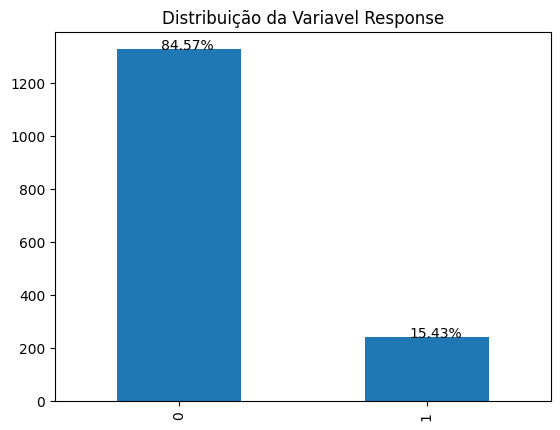

In [330]:
#visualizando a distribuição da variavel target 
ax = df_train.Response.value_counts().plot(kind='bar')
plt.title('Distribuição da Variavel Response')
for p in ax.patches: # patches pega as colunas 
  #multiplicando o tamanho da coluna por 100 e dividindo pelo tamanho da variavel target
  ax.annotate('{:.2f}%'.format(100*p.get_height()/len(df_train.Response)), (p.get_x()+ 0.18, p.get_height()))

É possivel perceber que o conjunto de treinamento segue a distribuiçao descrita no contexto do problema apenas 15% dos clientes compraram o produto 

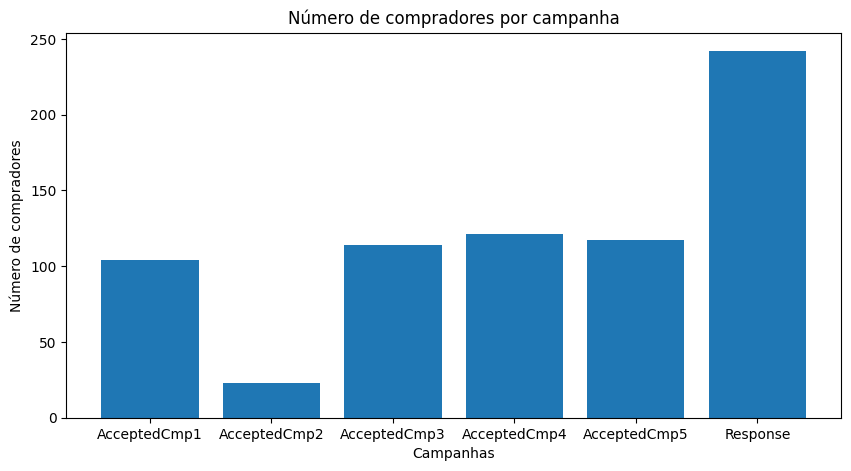

In [331]:
# selecionando as colunas de campanha.
df_cmp = df_train[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5','Response']]
# calculando o número de compradores para cada campanha (somando os 1)
compraram = df_cmp.sum()

#plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(compraram.index, compraram)
ax.set_xlabel("Campanhas")
ax.set_ylabel("Número de compradores")
ax.set_title("Número de compradores por campanha")
plt.show()


A segunda camapanha teve desempenho muito inferior as demais camapanhas, visualizar

In [332]:
# Criando uma nova coluna chamada 'TotalComprou' baseada nas campanhas anteriores 
df_train['TotalComprou'] = df_train[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].sum(axis=1)


- Para uma melhor visualização do relacionamento das campanhas anteriores com outras features estou criando a feature TotalComprou que representa a soma de compras das campanhas anteriores

Text(0.5, 1.0, 'Distribuição da variavel Renda')

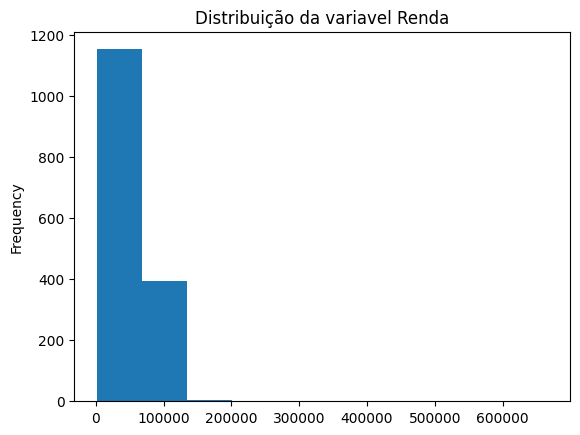

In [333]:
#verificando a distribuição da feature Income
df_train.Income.plot(kind = 'hist')
plt.title('Distribuição da variavel Renda')

In [334]:
#visualizando os percentis da variavel Income 
df_train.Income.describe(percentiles = [0.10, 0.25,0.5,0.75,0.99])

count      1553.000000
mean      52582.884739
std       26383.798056
min        1730.000000
10%       24342.200000
25%       35860.000000
50%       51983.000000
75%       69016.000000
99%       94075.120000
max      666666.000000
Name: Income, dtype: float64

In [335]:
#Trunkando a Variavel Income em percentil 99%
p99 = df_train['Income'].quantile(0.99)
df_train['Income'] = np.where(df_train['Income'] > p99, p99, df_train['Income'])

- Eu trunkei a Feature Income em 99% para remover os outliers porem posso voltar aqui e optar por outra abordagem como remover esses valores 

Text(0.5, 1.0, 'Distribuição da renda por nível de educação dos clientes com relação à campanhas anteriores')

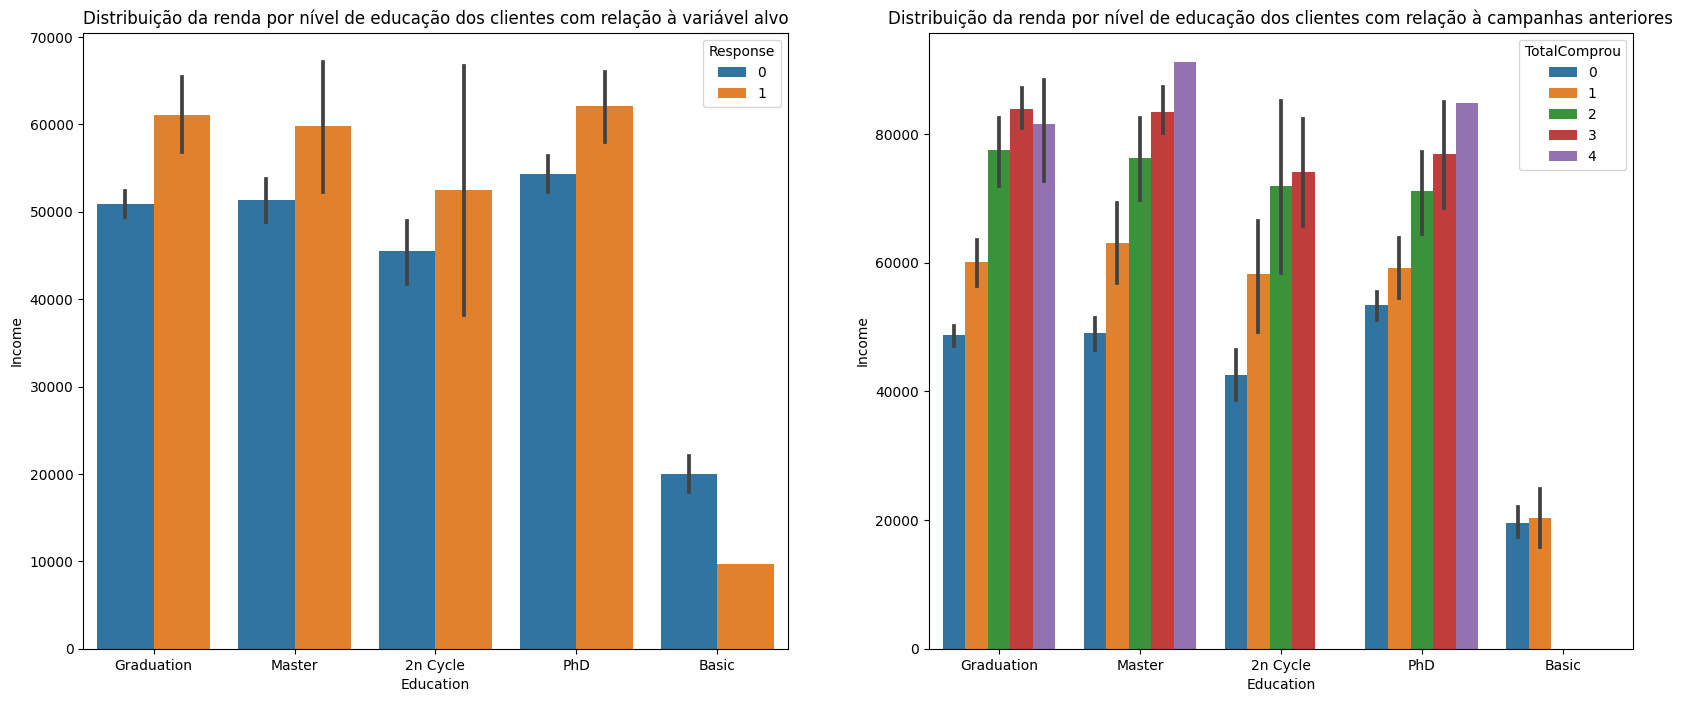

In [336]:
#verificando se o nivel de escolaridade influencia na obtenção do produto. 
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.barplot(data=df_train, x='Education', y='Income', hue='Response')
plt.title('Distribuição da renda por nível de educação dos clientes com relação à variável alvo')

plt.subplot(1,2,2)
sns.barplot(data=df_train, x='Education', y='Income', hue='TotalComprou')
plt.title('Distribuição da renda por nível de educação dos clientes com relação à campanhas anteriores')

Os clientes que adquiriram o produto apresentam um nível de escolaridade ligeiramente superior em comparação aos clientes que não adquiriram. No entanto, essa diferença não é muito significativa.

In [337]:
#visualizando a compra do produto na campanha de marketing (target)
#Mnt = pd.DataFrame(df_train, columns=['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds','Response'])
#sns.pairplot(Mnt, hue='Response',markers=["o", "s"],height=1.7, aspect=1.5)

Não existe uma correlação muito espressiva entre os produtos oferecidos, é possivel perceber que existe alguns outliers e que a grande maioria das pessoas que adquiriram o novo produto pela ultima campanha de marketing(target), ja fizeram muitas compras de algum outro produto.

In [338]:
#visualizando as compras do produto em campanhas de marketing anteriores. 
#Mnt = pd.DataFrame(df_train, columns=['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds','TotalComprou'])
#sns.pairplot(Mnt, hue='TotalComprou',height=1.7, aspect=1.5)

Fica mais nitido visualizar que os clientes que adquiriram o produto da campanha de marketing são clientes que ja compram algum produto com frequencia. 

Text(0, 0.5, 'N de Clientes que adquiriu o produto')

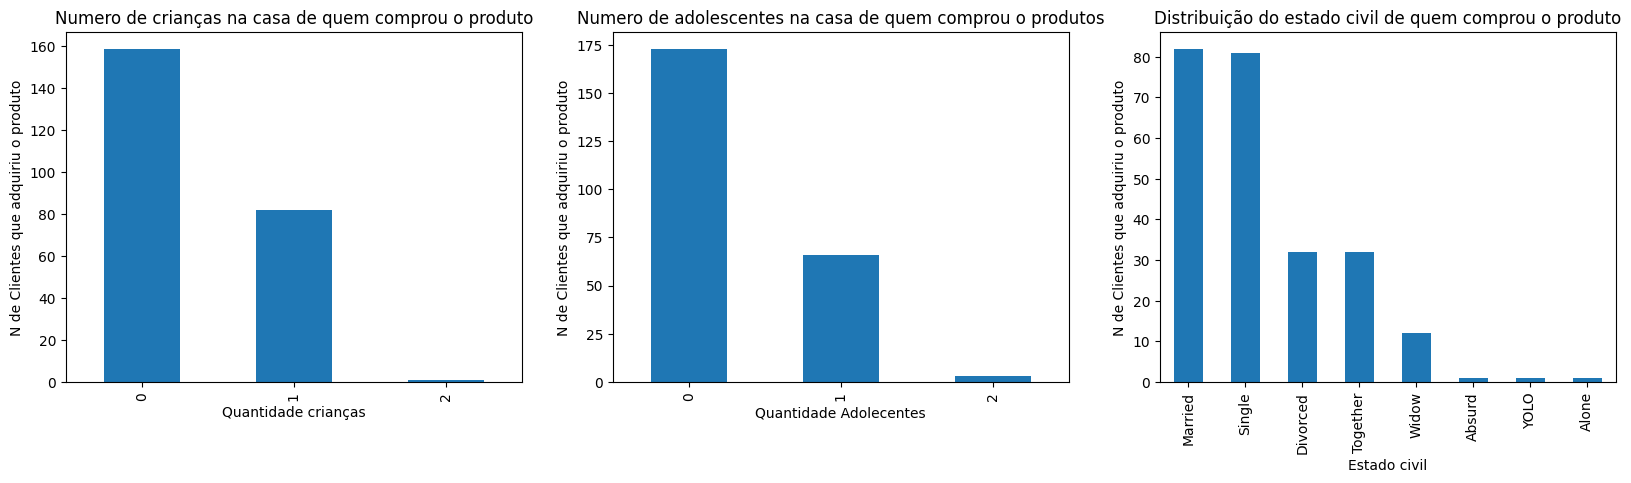

In [339]:
#plotando se existe diferença na quantidade de produtos adquiridos por pessoas que possuem filhos e por estado civil
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
df_train[df_train.Response == 1]['Kidhome'].value_counts().plot(kind='bar')
plt.title('Numero de crianças na casa de quem comprou o produto')
plt.xlabel('Quantidade crianças')
plt.ylabel('N de Clientes que adquiriu o produto')

plt.subplot(2,3,2)
df_train[df_train.Response == 1]['Teenhome'].value_counts().plot(kind='bar')
plt.title('Numero de adolescentes na casa de quem comprou o produtos')
plt.xlabel('Quantidade Adolecentes')
plt.ylabel('N de Clientes que adquiriu o produto')

plt.subplot(2,3,3)
df_train[df_train.Response == 1]['Marital_Status'].value_counts().plot(kind='bar')
plt.title('Distribuição do estado civil de quem comprou o produto')
plt.xlabel('Estado civil')
plt.ylabel('N de Clientes que adquiriu o produto')


- É possivel perceber que possuir filhos sejam eles crinças ou adolescente pode influenciar na aquisição do produto, ja o estado civil não parece ter alguma influencia mas tem algumas informações que não fazem muito sentido 

Text(0.5, 1.0, 'Diferença de renda de quem comprou ou não o produto')

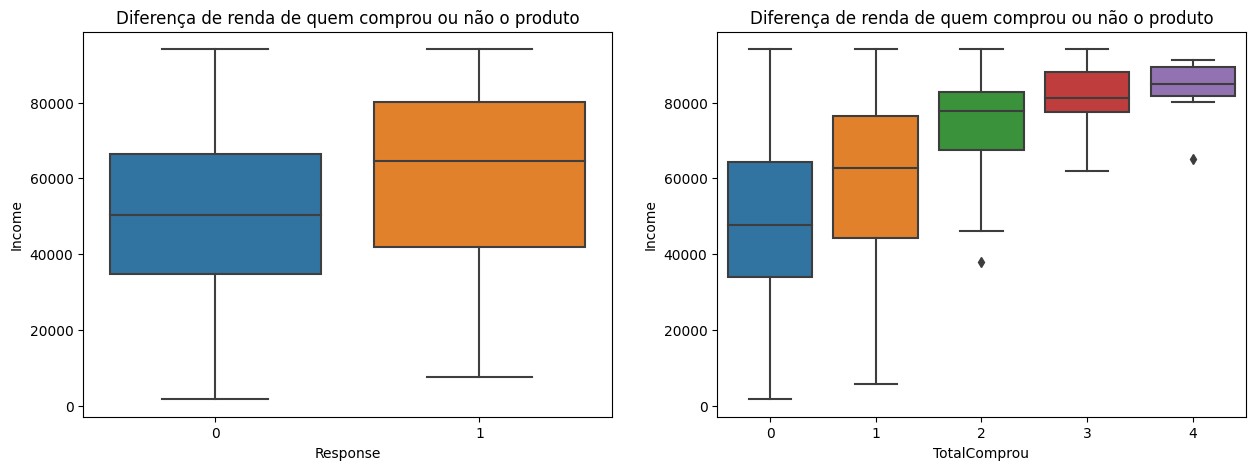

In [340]:
#verificando se existe diferença em quem adquiriu o produto e quem não adquiriu pelo valor da renda. 
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.boxplot(x="Response", y="Income", data=df_train)
plt.title('Diferença de renda de quem comprou ou não o produto')

plt.subplot(1,2,2)
sns.boxplot(x="TotalComprou", y="Income", data=df_train)
plt.title('Diferença de renda de quem comprou ou não o produto')

E possivel perceber que ter uma renda maior influencia se o cliente ira adquirir o produto. 

Text(0.5, 1.0, 'Qauntidade de Gold Products comprados x Renda')

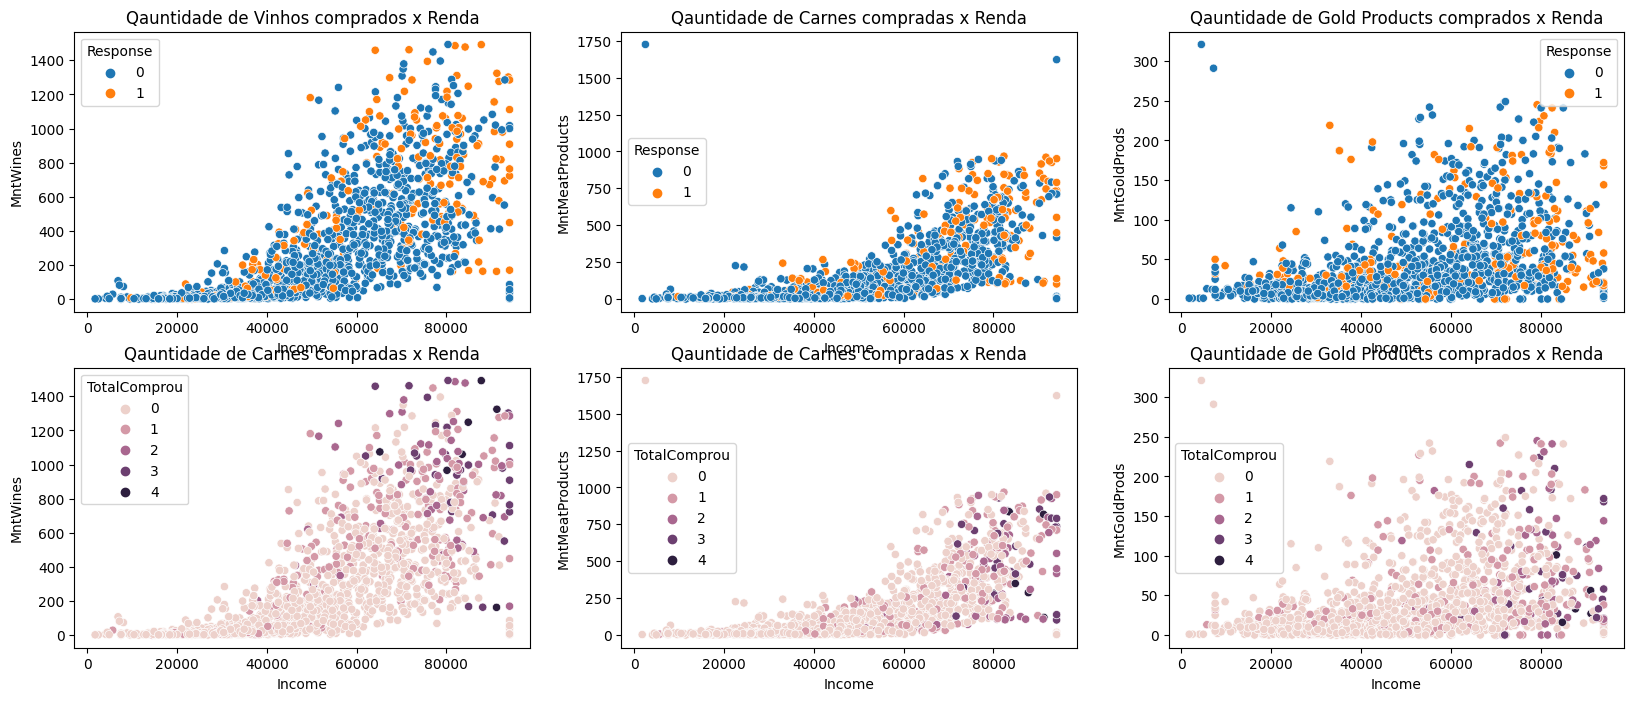

In [341]:
#verificando a relação de alguns produtos com a renda e onde estão os clientes que adquiriram o produto da campanha de marketing
plt.figure(figsize=(20,8))

plt.subplot(2,3,1)
sns.scatterplot(x='Income', y='MntWines', hue='Response', data=df_train)
plt.title('Qauntidade de Vinhos comprados x Renda')
plt.subplot(2,3,2)
sns.scatterplot(x='Income', y='MntMeatProducts', hue='Response', data=df_train)
plt.title('Qauntidade de Carnes compradas x Renda')
plt.subplot(2,3,3)
sns.scatterplot(x='Income', y='MntGoldProds', hue='Response', data=df_train)
plt.title('Qauntidade de Gold Products comprados x Renda')

#Vizualizando pela feature Totalcomprou
plt.subplot(2,3,4)
sns.scatterplot(x='Income', y='MntWines', hue='TotalComprou', data=df_train)
plt.title('Qauntidade de Carnes compradas x Renda')
plt.subplot(2,3,5)
sns.scatterplot(x='Income', y='MntMeatProducts', hue='TotalComprou', data=df_train)
plt.title('Qauntidade de Carnes compradas x Renda')
plt.subplot(2,3,6)
sns.scatterplot(x='Income', y='MntGoldProds', hue='TotalComprou', data=df_train)
plt.title('Qauntidade de Gold Products comprados x Renda')

é possivel perceber que os clientes que possuem mais renda adquirem mais produtos, e respondem mais as campanhas de marketing. 

Text(0, 0.5, 'Numero de visitas no site')

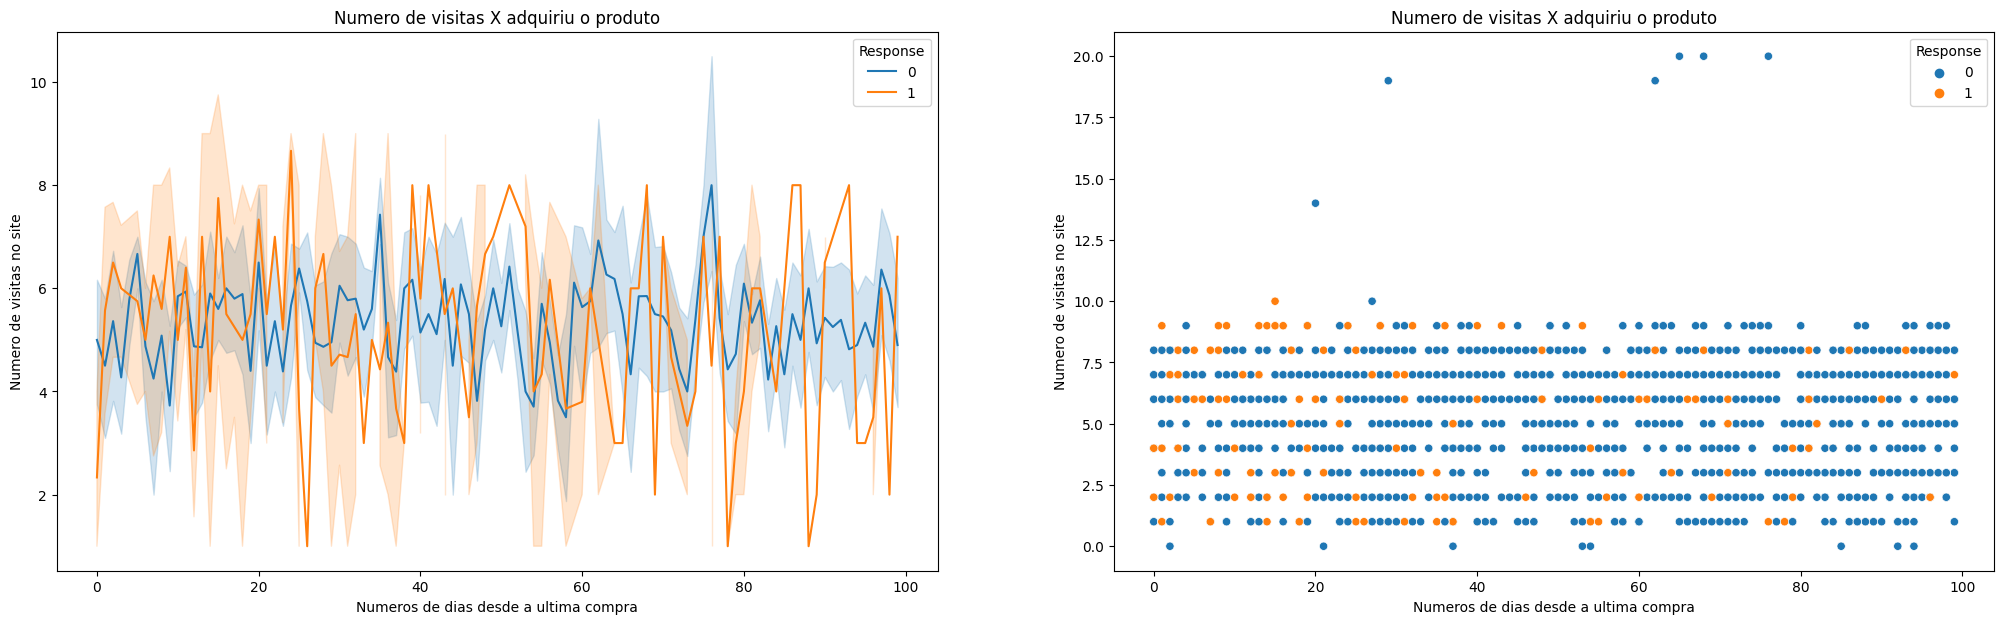

In [342]:
#vendo o numero de visitas no site desde a ultima compra e comparando com quem adquiriu o produto

# Criando um dataframe com as features NumWebVisitsMonth, Recency e Response
df_lineplot = df_train[['NumWebVisitsMonth', 'Recency', 'Response']]

# Plotando o line plot
plt.figure(figsize=(25,7))
plt.subplot(1,2,1)
sns.lineplot(data=df_train, x='Recency', y='NumWebVisitsMonth', hue='Response')
plt.title('Numero de visitas X adquiriu o produto')
plt.xlabel('Numeros de dias desde a ultima compra')
plt.ylabel('Numero de visitas no site')


plt.subplot(1,2,2)
sns.scatterplot(data=df_train, x='Recency', y='NumWebVisitsMonth', hue='Response')
plt.title('Numero de visitas X adquiriu o produto')
plt.xlabel('Numeros de dias desde a ultima compra')
plt.ylabel('Numero de visitas no site')


- aparentemente os clientes que adquiriram o produto da campanha de marketing visitaram o site mais rescentemente nos ultimos 40 dias. 

Text(0.5, 1.0, 'Numero de Compras com Desconto X Adquiriu o produto')

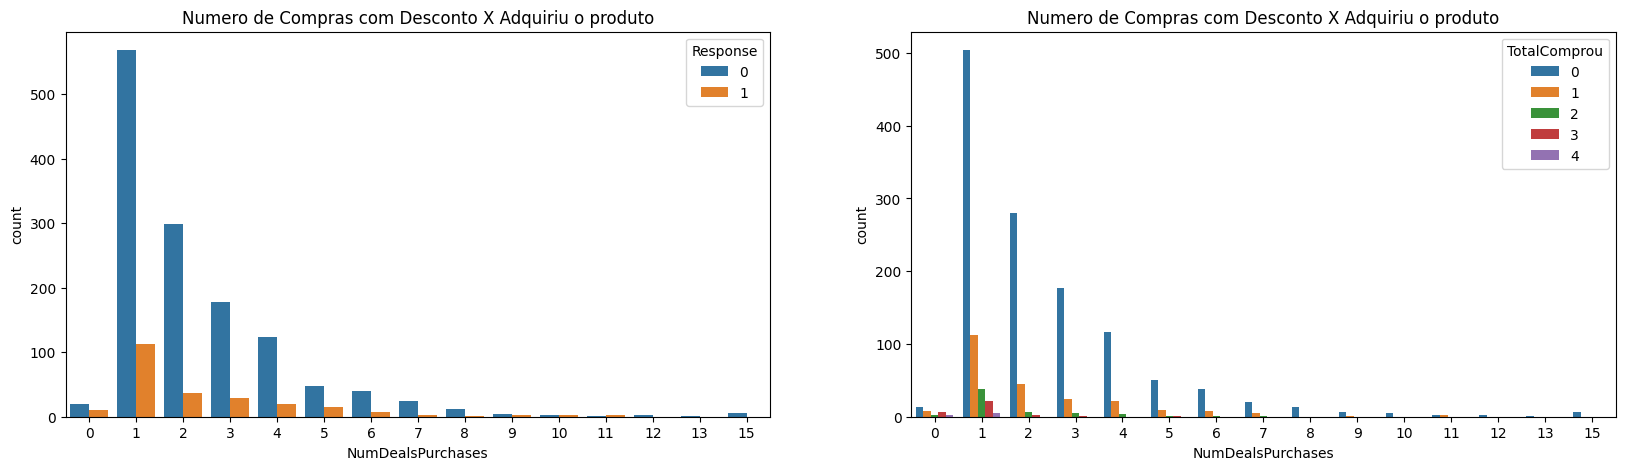

In [343]:
#visualizando o numero de compras feita com desconto com o fato de ter adquirido o produto 
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.countplot(x='NumDealsPurchases', hue='Response', data=df_train)
plt.title('Numero de Compras com Desconto X Adquiriu o produto')

#numero de compras com desconto x total Comprou 
plt.subplot(1,2,2)
sns.countplot(x='NumDealsPurchases', hue='TotalComprou', data=df_train)
plt.title('Numero de Compras com Desconto X Adquiriu o produto')

Aparentemente o cliente ter comprado mais produtos com desconto não o faz ser mais responsivo a campanha do novo produto. 

In [344]:
# Transforma a coluna Dt_Customer em um objeto datetime
df_train['Dt_Customer'] = pd.to_datetime(df_train['Dt_Customer'])

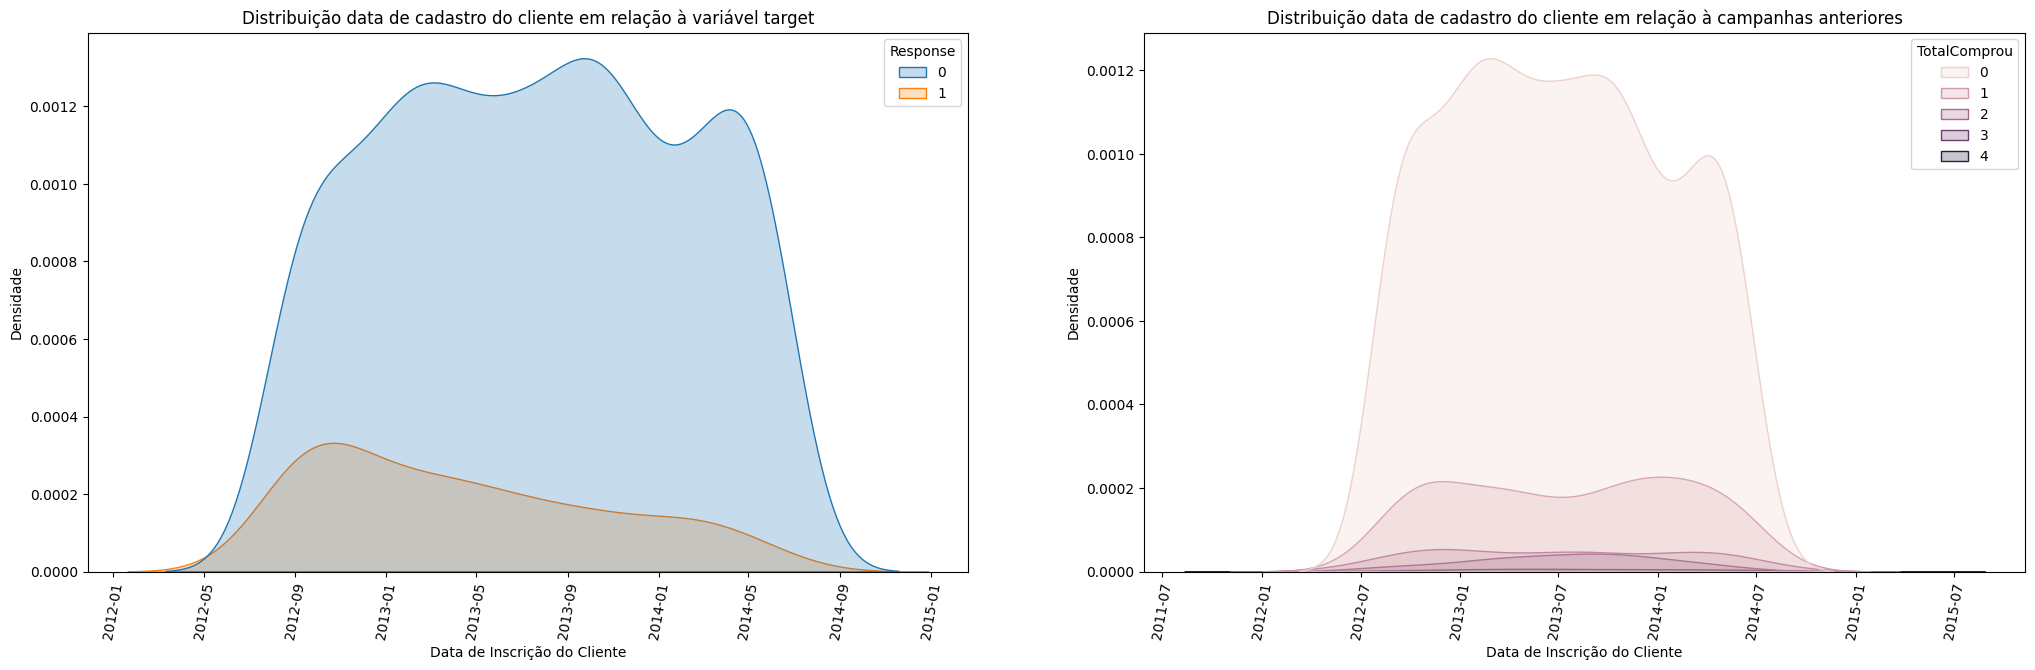

In [345]:
#"Distribuição data de cadastro do cliente em relação à campanhas
plt.figure(figsize=(25,7))
plt.subplot(1,2,1)
sns.kdeplot(data=df_train, x="Dt_Customer", hue="Response", fill=True)
plt.title("Distribuição data de cadastro do cliente em relação à variável target")
plt.xlabel("Data de Inscrição do Cliente")
plt.ylabel("Densidade")
plt.xticks(rotation =80)

plt.subplot(1,2,2)
sns.kdeplot(data=df_train, x="Dt_Customer", hue="TotalComprou", fill=True)
plt.title("Distribuição data de cadastro do cliente em relação à campanhas anteriores")
plt.xlabel("Data de Inscrição do Cliente")
plt.ylabel("Densidade")
plt.xticks(rotation =80)
plt.show()

Quando eu olho para minha variavel target, aparentemente os clientes que responderam a campanha tendem a ser clientes mais antigos e quanto mais novo o cliente menor a chance dele responder a campanha de marketing. 
Quando eu olho as pessoas que responderam as campanhas anteriores existe essa relação porem ela e menos evidente.

Text(0.5, 1.0, 'Distribuição da data de nascimento ')

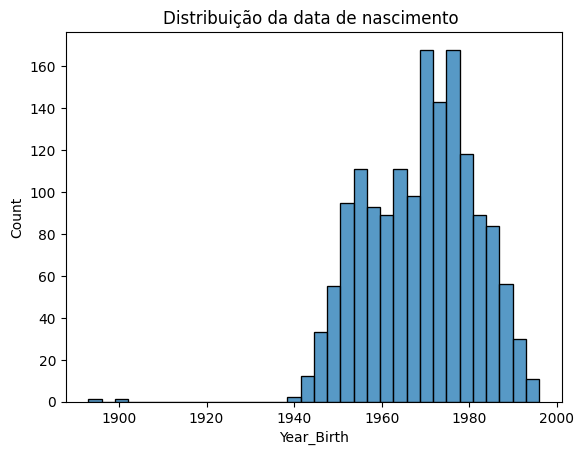

In [346]:
#visualizando a distribuição da data de nascimento 
sns.histplot(df_train.Year_Birth)
plt.title('Distribuição da data de nascimento ')

In [347]:
#visualizando os 5 menores valores 
df_train.Year_Birth.nsmallest(5)

239     1893
192     1900
1950    1940
424     1941
894     1943
Name: Year_Birth, dtype: int64

- temos apenas 2 linhas outliers eu vou optar por removelas. 

In [348]:
#deletando as 2 linhas outliers de data de nascimento 
df_train.drop(df_train[df_train.Year_Birth <= 1900].index,inplace = True)

# Criando uma feature que diz a idade do cliente
df_train["Age"] = 2023 - df_train["Year_Birth"]


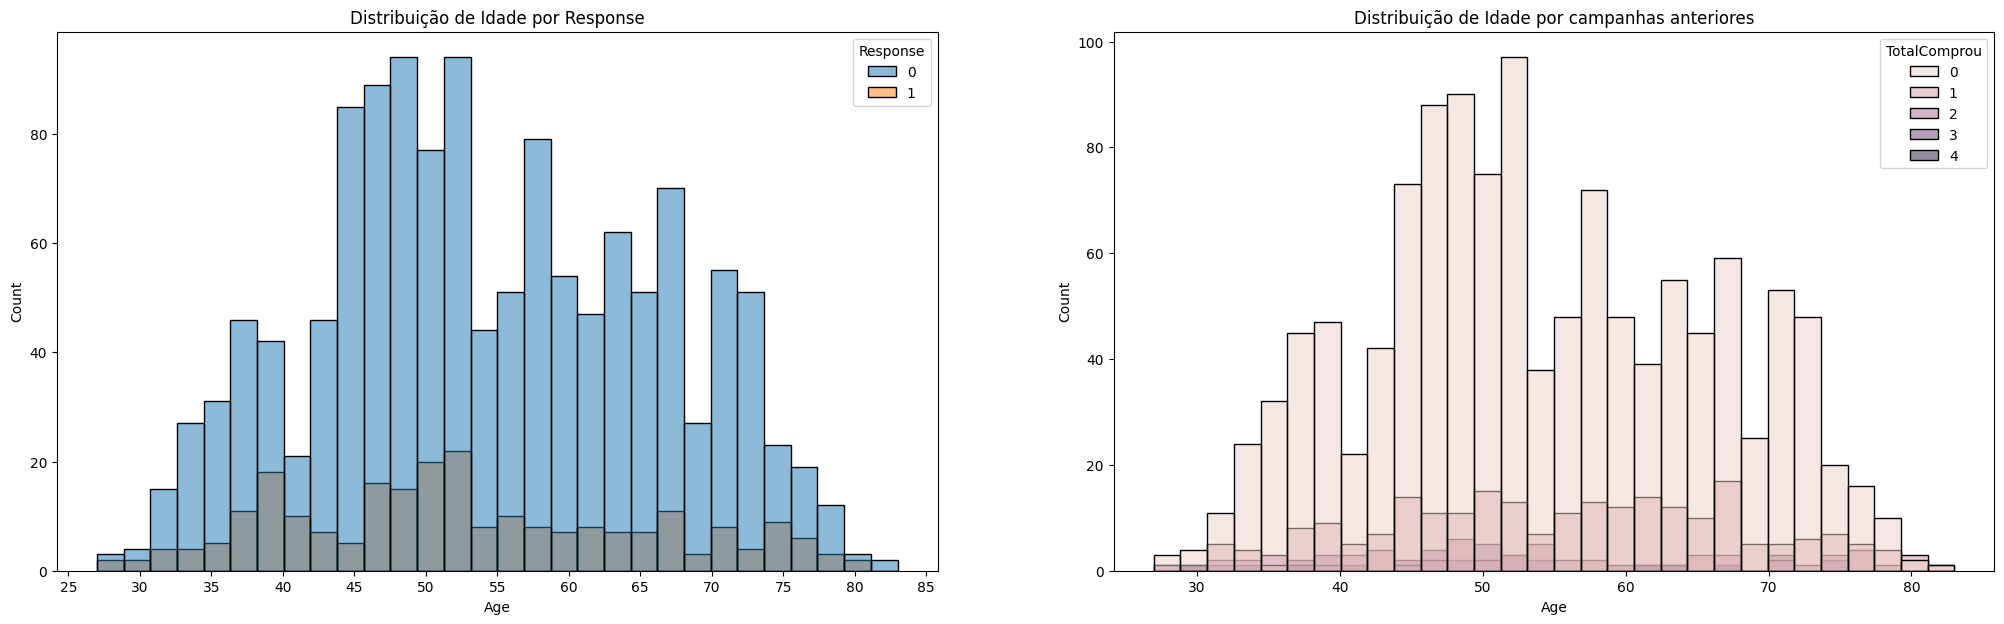

In [349]:
#visualizando a distribuição de idade de quem respondeu a campanha 
plt.figure(figsize=(25,7))
plt.subplot(1,2,1)
sns.histplot(data=df_train, x='Age', hue='Response', kde=False, bins=30)
plt.title('Distribuição de Idade por Response')
plt.xticks(range(25, 90, 5))
plt.subplot(1,2,2)
sns.histplot(data=df_train, x='Age', hue='TotalComprou', kde=False, bins=30)
plt.title('Distribuição de Idade por campanhas anteriores')
plt.show()

olhando a distribuição de idade de quem adquiriu o produto, podemos perceber que a distribuição e quase uniforme com alguns picos em determinadas faixas de idade. 

##Pre-Processamento para modelagem

#### Dados nulos


In [350]:
#verificando os dados nulos 
df_train.isnull().mean()[df_train.isnull().mean() > 0].sort_values(ascending=False)


Income    0.009579
dtype: float64

- só temos renda com poucos dados faltantes vou realizar a imputação pela Median() com base em nivel de educação.

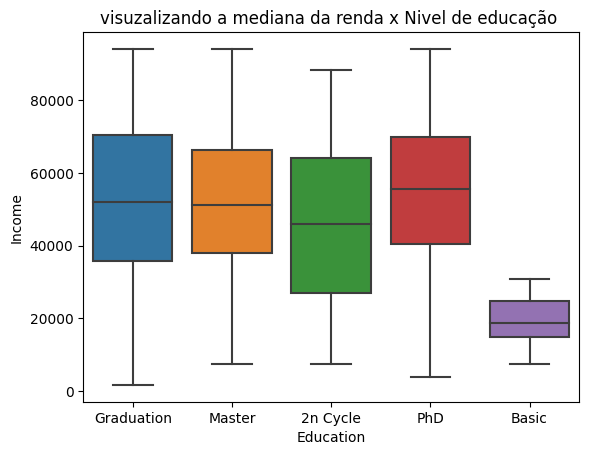

In [351]:
#visualizando a mediana de renda por nivel de educação 
sns.boxplot(x='Education', y='Income', data=df_train)
plt.title('visuzalizando a mediana da renda x Nivel de educação ')
plt.show()

In [352]:
#calculando a mediana de renda por nivel de educação 
median_income_by_education = df_train.groupby('Education')['Income'].median()

df_train['Income'] = df_train.apply(
    lambda row: median_income_by_education[row['Education']] if pd.isna(row['Income']) else row['Income'], 
    axis=1
)

- a função apply para aplicar a mediana correspondente a cada linha onde a renda é nula e manter o valor original quando não for nulo. Note que a condição pd.isna(row['Income']) verifica se o valor da renda é nulo.
- se achar necessario retorno aqui e aplico outra tecnica de imputação ou removo as poucas linhas com dados nulos

#### Dropando colunas que não pretendo usar a principio 

In [353]:
#fazendo um backup do df_train
copy_df_train = df_train.copy()

In [354]:
#Dropando colunas que não pretendo usar 
df_train = df_train.drop(['Year_Birth','Z_Revenue','Z_CostContact','Dt_Customer'],axis = 1)

- Estou removendo **year_birth** por que criei outra feature Age 
- **z_Revenue** e **Z_costContact**, não tenho informações sobre o que essas features representam e ambas possuem somente um unico valor então seram removidas também.
- **Dt_Customer** apesar de eu ter visto uma pequena relação com a variavel response, não consegui um bom desempenho tentando criar novas features com essa variavel então eu vou remover por hora.

#### Ajustando dados das variaveis categoricas 

In [355]:
#tratando os dados da variavel Marital_Status
df_train.Marital_Status = df_train.Marital_Status.replace('Together', 'Married')
df_train.Marital_Status = df_train.Marital_Status.replace('Alone', 'Single')
df_train.drop(df_train[df_train.Marital_Status =='Absurd'].index, inplace = True)
df_train.drop(df_train[df_train.Marital_Status =='YOLO'].index, inplace = True)

In [356]:
#checando os valores de Marital_status
df_train.Marital_Status.value_counts()

Married     997
Single      346
Divorced    166
Widow        55
Name: Marital_Status, dtype: int64

#### Preparando os dados para modelagem baseline 

In [357]:
#fazendo one hot nas variaveis categoricas para o modelo baseline
df_train_baseline = pd.get_dummies(df_train, columns=['Education','Marital_Status'], drop_first=True)

In [358]:
#separando os dados da variavel target em X e y
X = df_train_baseline.drop('Response', axis = 1)
y = df_train_baseline['Response']

In [359]:
#divindo em treino e validação baselines 
X_train_baseline, X_val_baseline, y_train_baseline, y_val_baseline = train_test_split(X, y,  test_size =0.3,random_state = 1603)

In [360]:
#verificando a quantidade de dados em X_train e X_val baseline 
X_train_baseline.shape, X_val_baseline.shape

((1094, 31), (470, 31))

Estou divindo o conjunto de treino em treino e validação para fazer tunagem de hiperparametros e outras coisas. 

## Baseline Model

In [361]:
#instanciando o modelo Random Forest
rfc = RandomForestClassifier(random_state=1603)

#treinando o modelo e fazendo o predict       
rfc.fit(X_train_baseline, y_train_baseline)
y_pred_train_rfc_baseline = rfc.predict(X_val_baseline)
print(classification_report(y_val_baseline, y_pred_train_rfc_baseline))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       407
           1       0.65      0.24      0.35        63

    accuracy                           0.88       470
   macro avg       0.77      0.61      0.64       470
weighted avg       0.86      0.88      0.86       470



Eu resolvi criar um modelo Baseline para ter um ponto de partida e saber o quanto o Featuare Engineering, Normalização, Clusterização entre outras tecnicas podem melhorar minhas metricas 
- Eu vou optar por priorizar o **F1 Score** acredito que seja a metrica mais viavel para este problema, tendo como segunda prioridade o **recall** 

## Feature Engineering

In [362]:
df_train['N_Filhos'] = df_train.Teenhome + df_train.Kidhome

- Faixa de idade 

- Total de produtos comprados
- Total de compras feitas 
- Algo relacionado a Dt_Customer
- Features categoricas das variaveis numericas baseadas nos quartis.

In [363]:
#criando uma função que cria faixas de idade apartir de Age 
def idade_group(x):
  if x <=35:
    return '18-35'
  elif x <= 45:
    return '36 - 45'
  elif x <= 55:
    return '46 - 55'
  elif x <= 65:
    return '56 - 65'
  elif x <= 75:
    return '66 - 75'
  else: 
    return '76+'    

#Criando a feature Faixas de idade e aplicando a função criada acima 
df_train['Faixa_idade'] = df_train['Age'].apply(idade_group)

In [364]:
#verificando a distribuição de faixas de idade 
df_train.Faixa_idade.value_counts()

46 - 55    510
56 - 65    332
36 - 45    308
66 - 75    288
18-35       79
76+         47
Name: Faixa_idade, dtype: int64

In [365]:
#criando uma feature chamada ProdutosTotais, que representa o numero total de produtos comprados 
df_train['ProdutosTotais'] = df_train[['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']].sum(axis=1)


In [366]:
df_train[['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds', 'ProdutosTotais']]

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,ProdutosTotais
2054,25,0,11,3,0,15,54
1862,162,50,100,55,30,27,424
144,32,34,41,73,16,116,312
836,191,9,97,0,6,82,385
76,721,111,925,97,18,18,1890
...,...,...,...,...,...,...,...
1241,46,1,12,3,0,9,71
428,2,2,11,10,6,12,43
1594,85,0,3,0,0,7,95
1165,441,35,83,7,29,11,606


In [367]:
#Criando a feature ComprasTotal que representa o numero total de compras efetuadas 
df_train['ComprasTotal'] = df_train[['NumDealsPurchases','NumCatalogPurchases','NumStorePurchases','NumWebPurchases']].sum(axis=1)

In [368]:
df_train[['NumDealsPurchases','NumCatalogPurchases','NumStorePurchases','NumWebPurchases','ComprasTotal']]

,NumDealsPurchases,NumCatalogPurchases,NumStorePurchases,NumWebPurchases,ComprasTotal
2054,1,0,3,1,5
1862,1,2,8,4,15
144,3,2,3,4,12
836,2,1,5,6,14
76,1,6,5,7,19
...,...,...,...,...,...
1241,2,0,3,2,7
428,2,0,4,1,7
1594,1,0,4,2,7
1165,4,2,12,4,22


## RFM

**RFM** é uma técnica de análise de dados usada para segmentar clientes com base em seu comportamento de compra. Essa técnica divide os clientes em três dimensões:

- **Recência (R):** o tempo desde a última compra do cliente;
- **Frequência (F):** a frequência de compras do cliente em um determinado período de tempo;
- **Monetaridade (M):** o valor total gasto pelo cliente em um determinado período de tempo.

A partir dessas três dimensões, os clientes podem ser segmentados em grupos com base em seu comportamento de compra. Por exemplo, clientes que fizeram compras recentes, com alta frequência e alto valor de compra seriam considerados clientes VIP, enquanto clientes que fizeram compras há muito tempo, com baixa frequência e baixo valor de compra podem ser considerados clientes inativos.

#### Recency

In [369]:
#vendo os quartis de Recency
df_train.Recency.describe()

count    1564.000000
mean       49.329923
std        28.691665
min         0.000000
25%        25.000000
50%        50.000000
75%        74.000000
max        99.000000
Name: Recency, dtype: float64

In [370]:
df_train['Recency_compra'] = pd.cut(df_train['Recency'],bins=[0, 25, 50, 75, np.inf], 
                                    labels=[0, 1, 2, 3]).astype("float").astype("Int64")


In [371]:
#verificando a distribuição dos grupos 
df_train.Recency_compra.value_counts()

1    393
2    391
0    389
3    376
Name: Recency_compra, dtype: Int64

#### Frequency

In [372]:
#visualizando os quartis de CompraTotal 
df_train.ComprasTotal.describe()

count    1564.000000
mean       15.065857
std         7.712451
min         0.000000
25%         8.000000
50%        16.000000
75%        21.000000
max        44.000000
Name: ComprasTotal, dtype: float64

In [373]:
#criando os grupos de frequencia com base nos quartils de CompraTotal
df_train['freq_compra'] = pd.cut(df_train['ComprasTotal'], bins=[0, 8, 15, 20, np.inf], 
                                  labels=[0, 1, 2, 3]).astype("float").astype("Int64")


- Em um mundo ideal eu teria uma feature com as datas das compras para calcular a frequencia, porem como não tenho estou utilizando  a feature que representa a soma do numero total de compras, inplicando que quanto mais compras o cliente tem maior a frequencia. 

In [374]:
#verificando a distribuição dos grupos 
df_train.freq_compra.value_counts()

3    435
0    434
2    354
1    339
Name: freq_compra, dtype: Int64

#### Monetary

In [375]:
#verificando os quartis de ProdutosTotais
df_train.ProdutosTotais.describe()

count    1564.000000
mean      616.444373
std       604.111452
min         6.000000
25%        71.000000
50%       408.000000
75%      1060.500000
max      2525.000000
Name: ProdutosTotais, dtype: float64

In [376]:
#criando  os grupos de Monetary com base nos quatis de ProdutosTotais
df_train['Monetary'] = pd.cut(df_train['ProdutosTotais'], bins=[0, 71, 408, 1060, np.inf], 
                                  labels=[0, 1, 2, 3]).astype("int")

Para criar os grupos de Monetary estou utilizando a feature ProdutosTotais que representa q quantidade total de produtos comprados por um cliente, quantos mais produtos comprados maior o poder monetario do cliente, novamente em um mundo ideal eu teria o valor dos produtos e poderia calcular de forma mais exata. 

In [377]:
#verificando a distribuição dos grupos 
df_train.freq_compra.value_counts()

3    435
0    434
2    354
1    339
Name: freq_compra, dtype: Int64

#### Correlação

In [378]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1564 entries, 2054 to 1329
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   1564 non-null   int64  
 1   Education            1564 non-null   object 
 2   Marital_Status       1564 non-null   object 
 3   Income               1564 non-null   float64
 4   Kidhome              1564 non-null   int64  
 5   Teenhome             1564 non-null   int64  
 6   Recency              1564 non-null   int64  
 7   MntWines             1564 non-null   int64  
 8   MntFruits            1564 non-null   int64  
 9   MntMeatProducts      1564 non-null   int64  
 10  MntFishProducts      1564 non-null   int64  
 11  MntSweetProducts     1564 non-null   int64  
 12  MntGoldProds         1564 non-null   int64  
 13  NumDealsPurchases    1564 non-null   int64  
 14  NumWebPurchases      1564 non-null   int64  
 15  NumCatalogPurchases  1564 non-null 

<ipython-input-383-53b6272dc69a>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_train.corr(), #Fonte dos dados, nossa matriz de correlação
<ipython-input-383-53b6272dc69a>:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  np.ones_like(df_train.corr()) # usando como base uma matriz de '1's, do mesmo tamanho que a matriz de correlação


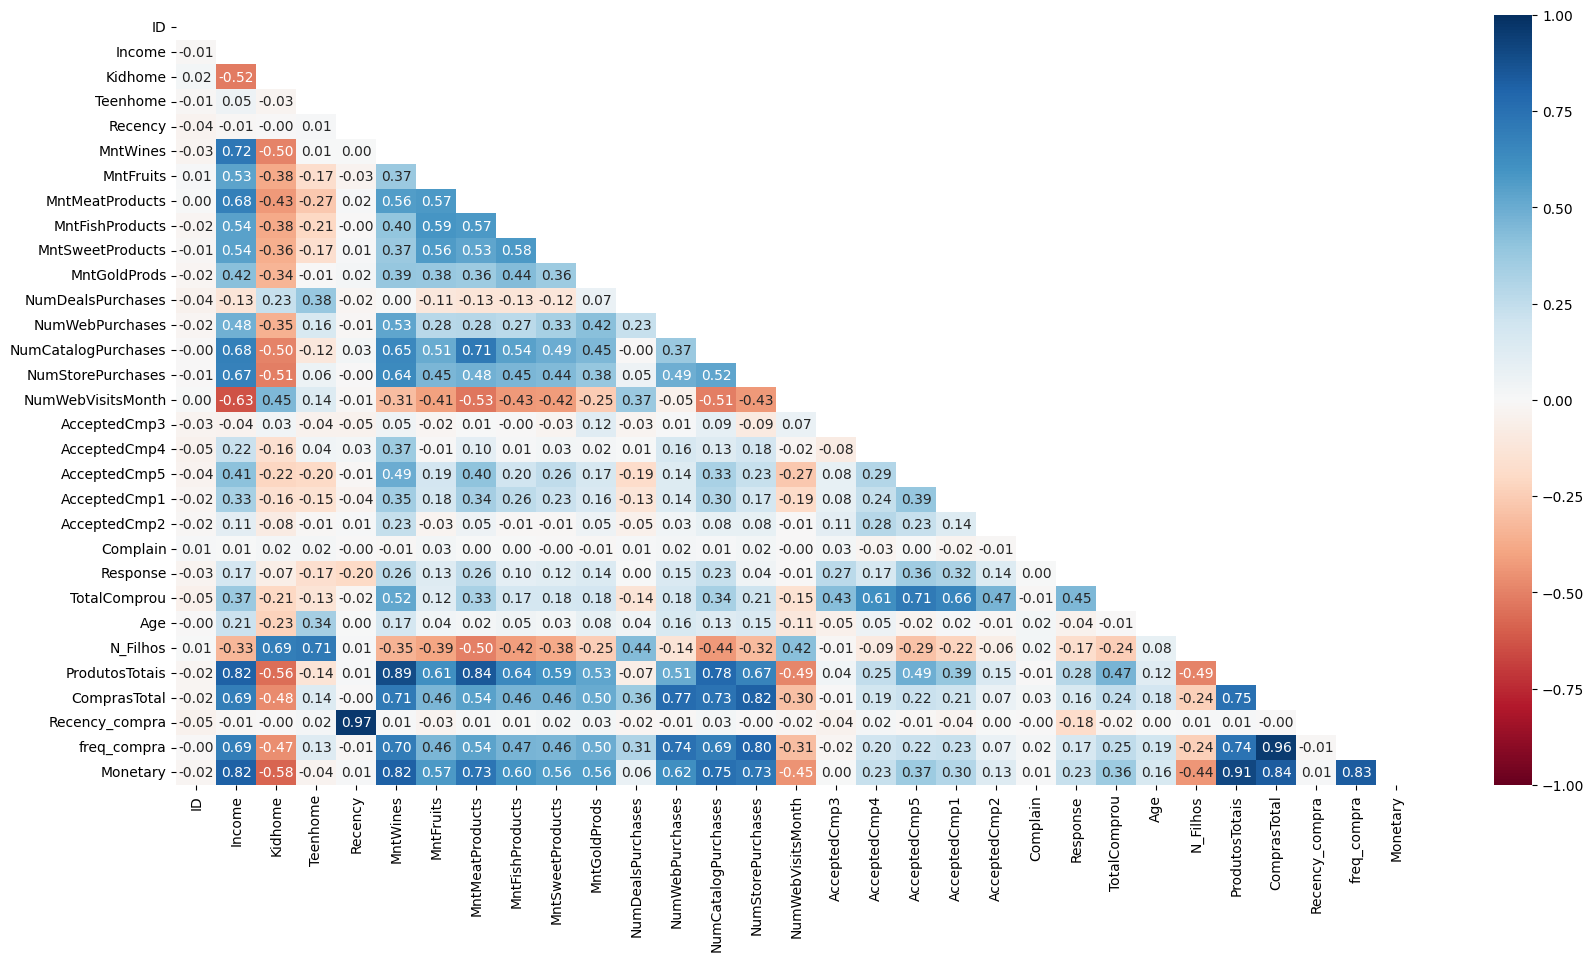

In [383]:
# Plotando a matriz de correlações usando um Heatmap para dar cor aos números
plt.figure(figsize=(20,10))
sns.heatmap(
    df_train.corr(), #Fonte dos dados, nossa matriz de correlação
    annot=True,
    fmt='.2f',
    vmin = -1,
    vmax = 1,
    cmap='RdBu', # Mapa de cores do vermelho (menor) para o azul (maior)
    mask=np.triu( # Faz uma matriz triangular
        np.ones_like(df_train.corr()) # usando como base uma matriz de '1's, do mesmo tamanho que a matriz de correlação
    ) # A máscara vai então 'apagar' a diagonal superior da matriz
           )
plt.show()

In [380]:
df_train.dropna(inplace=True)

#### Checar a distribuição das minhas variaveis numericas 

####Escala e normalização dos dados 

In [ ]:
from scipy.special import boxcox1p
variables = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 
             'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases','NumWebVisitsMonth']

for var in variables:
    df_train[var] = boxcox1p(df_train[var] +1 , 0.01)


In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

#Colocando a variavel age e Fare em uma escala menor 
df_train[['Income','Age']] = sc.fit_transform(df_train[['Income','Age',]])